In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from IPython.display import display

import os
import sys
import pandas as pd
import numpy as np
import dill

from sklearn import linear_model, ensemble, neural_network, neighbors, svm, tree
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import *

from sklearn.decomposition import PCA


# add the root of the repository to the python path
sys.path.insert(0, "..")

from preprocessing import *
from evaluation import *
from paths import *

### Loading the data
We begin by loading our preprocessed dataset. To prepare the data, we have done the following:
- We onehot encoded categorical features.
- We imputed missing data. We use regression imputation to impute BMI (continuous) and logistic regression to impute smoking (categorical).
- We normalized all features to mean=0 and variance=1. 

In [2]:
# load the raw data
data = pd.read_csv(data_dir / "stroke_all.csv")
train_data = pd.read_csv(data_dir / "stroke_train.csv")
raw_X, raw_y = data.iloc[:, 1:-1], data.iloc[:, -1].to_numpy().reshape(-1,1)
raw_X_train, raw_y_train = train_data.iloc[:, 1:-1], train_data.iloc[:, -1].to_numpy().reshape(-1,1)

# load the data we have preprocessed (see the data_wrangling.ipynb notebook for our preprocessing methods)
X, y = get_preprocessed_data(write=False, datafile="stroke_all.csv")
X_train, y_train = get_preprocessed_data(write=False, datafile="stroke_train.csv")
X_test, y_test = get_preprocessed_data(write=False, datafile="stroke_test.csv")

../preprocessing.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target[nan_values] = regression.predict(X[nan_values])
../preprocessing.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target[nan_values] = regression.predict(X[nan_values])
../preprocessing.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target[nan_values] = regression.predict(X[nan_values])
../preprocessing.py:37: SettingWithCopyWarning: 
A value is trying 

### Exploring the data

Below we visualize the unprocessed training data. We drop the `id` feature and onehot encode the `gender, ever_married, work_type, Residence_type` and `smoking_status` features.

In [3]:
display(train_data)

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,30669,Male,3.0,0,0,No,children,Rural,95.12,18.0,NaN,0
1,16523,Female,8.0,0,0,No,Private,Urban,110.89,17.6,NaN,0
2,56543,Female,70.0,0,0,Yes,Private,Rural,69.04,35.9,formerly smoked,0
3,46136,Male,14.0,0,0,No,Never_worked,Rural,161.28,19.1,NaN,0
4,32257,Female,47.0,0,0,Yes,Private,Urban,210.95,50.1,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...
28649,45266,Female,18.0,0,0,No,Private,Urban,131.96,22.8,NaN,0
28650,69344,Male,39.0,0,0,Yes,Private,Rural,132.22,31.6,never smoked,0
28651,5450,Female,56.0,0,0,Yes,Govt_job,Urban,213.61,55.4,formerly smoked,0
28652,27973,Male,40.0,0,0,Yes,Private,Urban,99.16,33.2,never smoked,0


Note the missing data for `smoking_status` and `bmi` (not visible), as well as the severe label imbalance. Focusing on these issues, we see the following:

In [4]:
pct_positive = 100 * y_train.mean()
pct_na_bmi = 100 * np.mean(pd.isna(raw_X[['bmi']]))
pct_na_smoking = 100 * np.mean(pd.isna(raw_X[['smoking_status']]))

print("Percent of positive labels: %.1f%%" % pct_positive)
print("Percent of missing BMI values in training data: %.1f%%" % pct_na_bmi)
print("Percent of missing smoking status values in training data: %.1f%%" % pct_na_smoking)

Percent of positive labels: 1.9%
Percent of missing BMI values in training data: 3.4%
Percent of missing smoking status values in training data: 30.6%


## Visualizing the data
To see if there is a clear separation based on the stroke outcome, we visualize the first two principle components of the data. Since the `stroke=1` class is very rare, we plot it on top so that the `stroke=0` and `stroke=1` classes can be effectively compared. We see that in general that there is little separation between the two distributions visible in the first two pricinciple components. 

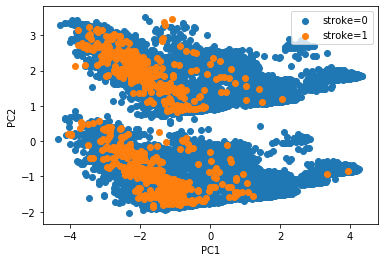

In [5]:
pca = PCA(n_components=2)
pca.fit(X)
X_pca = pca.fit_transform(X)

plt.scatter(X_pca[:,0][y.flatten() == 0], X_pca[:,1][y.flatten() == 0], label="stroke=0")
plt.scatter(X_pca[:,0][y.flatten() == 1], X_pca[:,1][y.flatten() == 1], label="stroke=1")
plt.legend()
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

# Modeling
We run seven learning algorithms to predict whether an individual will experience a stroke:
- Logistic Regression
- Decision Tree
- k-Nearest Neighbors
- Support Vector Machine
- Random Forest
- AdaBoost
- Neural Network

For each learning algorithm we run an exhaustive search over a hyperparameter grid using 3-fold cross-validation to determine the best model settings. Since the exhaustive hyperparameter search requires training hundreds of models, it takes about 45 minutes to train all of the models on a 2019 Macbook Pro. Thus, we provide pre-trained models to save you time. You can retrain all of the models yourself by setting `TRAIN_ALL=True`, or you can choose to retrain a specific model by setting any of the individual flags to `True`. 

In [6]:
# Code to run logistic regression (first unweighted, then with class weights)

TRAIN_ALL = False

TRAIN_LR = False
TRAIN_ADB = False
TRAIN_DT = False
TRAIN_MLP = False
TRAIN_SVM = False
TRAIN_KNN = False
TRAIN_RF = False

# Settings for the cross-validation used in the exhaustive hyperparameter searches
cross_validation_args = {"verbose": 1, # print to console
                         "n_jobs": -1, # use parallelization
                         "cv": 3, # number CV folds (needs to be small to compute exhaustive hyperparameter search)
                         "scoring": make_scorer(roc_auc_score, needs_proba=True), # choose best hyperparams using AUC
                         }

#### Logistic Regression
if TRAIN_LR or TRAIN_ALL:
    lr = GridSearchCV(linear_model.LogisticRegression(),
                      param_grid={"max_iter": [500],
                                  "penalty": ['elasticnet'],
                                  "solver": ["saga"],
                                  "l1_ratio": [0.1, 0.3, 0.5, 0.7, 0.9],
                                  "class_weight": [{1:5}, {1:10}, {1:20}, {1:50}, {1:100}]},
                      **cross_validation_args)
    lr.fit(X_train, y_train)
    with open(model_dir / "lr.pickle", "wb") as f:
        dill.dump(lr, f)
with open(model_dir / "lr.pickle", "rb") as f:
    lr = dill.load(f)

#### AdaBoost
if TRAIN_ADB or TRAIN_ALL:
    adb = GridSearchCV(ensemble.AdaBoostClassifier(),
                       param_grid={"n_estimators": [10, 20, 50, 100, 200],
                                   "learning_rate": [0.5, 1.0, 1.5, 2.0]},
                       **cross_validation_args)
    adb.fit(X_train, y_train)
    with open(model_dir / "adb.pickle", "wb") as f:
        dill.dump(adb, f)
with open(model_dir / "adb.pickle", "rb") as f:
    adb = dill.load(f)

#### Decision Tree
if TRAIN_DT or TRAIN_ALL:
    dt = GridSearchCV(tree.DecisionTreeClassifier(),
                      param_grid={"criterion": ["gini", "entropy"],
                                  "max_depth": [3, 5, 10, None],
                                  "class_weight": [{1:5}, {1:10}, {1:20}, {1:50}, {1:100}]},
                      **cross_validation_args)
    dt.fit(X_train, y_train)
    with open(model_dir / "dt.pickle", "wb") as f:
        dill.dump(dt, f)
with open(model_dir / "dt.pickle", "rb") as f:
    dt = dill.load(f)

#### Neural Network
if TRAIN_MLP or TRAIN_ALL:
    mlp = GridSearchCV(neural_network.MLPClassifier(),
                       param_grid={"hidden_layer_sizes": [(10, 10), (15, 15), (50, 50), (100, 100), (10, 10, 10),
                                                          (15, 15, 10), (50, 50, 10), (100, 100, 10)]},
                       **cross_validation_args)
    mlp.fit(X_train, y_train)
    with open(model_dir / "mlp.pickle", "wb") as f:
        dill.dump(mlp, f)
with open(model_dir / "mlp.pickle", "rb") as f:
    mlp = dill.load(f)
    
#### k-Nearest Neighbors
if TRAIN_KNN or TRAIN_ALL:
    knn = GridSearchCV(neighbors.KNeighborsClassifier(),
                       param_grid={"n_neighbors": [1, 2, 5, 10, 20, 50]},
                       **cross_validation_args)
    knn.fit(X_train, y_train)
    with open(model_dir / "knn.pickle", "wb") as f:
        dill.dump(knn, f)
with open(model_dir / "knn.pickle", "rb") as f:
    knn = dill.load(f)
    
#### Support Vector Machine
if TRAIN_SVM or TRAIN_ALL:
    svc = GridSearchCV(svm.SVC(),
                       param_grid={"kernel": ['rbf', 'linear', 'sigmoid'],
                                   "class_weight": [{1:5}, {1:10}, {1:20}, {1:50}, {1:100}],
                                   "probability": [True]},
                       **cross_validation_args)
    svc.fit(X_train, y_train)
    with open(model_dir / "svc.pickle", "wb") as f:
        dill.dump(svc, f)
with open(model_dir / "svc.pickle", "rb") as f:
    svc = dill.load(f)
    
#### Support Vector Machine
if TRAIN_RF or TRAIN_ALL:
    rf = GridSearchCV(ensemble.RandomForestClassifier(),
                       param_grid={"n_estimators": [10, 30, 50, 100, 200],
                                   "max_depth": [3, 5, 10, None]},
                       **cross_validation_args)
    rf.fit(X_train, y_train)
    with open(model_dir / "rf.pickle", "wb") as f:
        dill.dump(rf, f)
with open(model_dir / "rf.pickle", "rb") as f:
    rf = dill.load(f)
    
    
models = [lr, adb, dt, mlp, knn, svc, rf]

# Evaluation

In [7]:
# generate each of the ROC curves
lr_fpr, lr_tpr, lr_thresholds = roc_curve(y_test, lr.predict_proba(X_test)[:, 1])
adb_fpr, adb_tpr, adb_thresholds = roc_curve(y_test, adb.predict_proba(X_test)[:, 1])
dt_fpr, dt_tpr, dt_thresholds = roc_curve(y_test, dt.predict_proba(X_test)[:, 1])
mlp_fpr, mlp_tpr, mlp_thresholds = roc_curve(y_test, mlp.predict_proba(X_test)[:, 1])
knn_fpr, knn_tpr, knn_thresholds = roc_curve(y_test, knn.predict_proba(X_test)[:, 1])
svc_fpr, svc_tpr, svm_thresholds = roc_curve(y_test, svc.predict_proba(X_test)[:, 1])
rf_fpr, rf_tpr, rf_thresholds = roc_curve(y_test, rf.predict_proba(X_test)[:, 1])

# plot the ROC curves together
plt.plot(lr_fpr, lr_tpr, label="Logistic Regression")
plt.plot(adb_fpr, adb_tpr, label="AdaBoost")
plt.plot(dt_fpr, dt_tpr, label="Decision Trees")
plt.plot(mlp_fpr, mlp_tpr, label="Neural Network")
plt.plot(svc_fpr, svc_tpr, label="Support Vector Machine")
plt.plot(knn_fpr, knn_tpr, label="k-Nearest Neighbors")
plt.plot(rf_fpr, rf_tpr, label="Random Forest")

plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("Test Set ROC Curve Comparison")
plt.legend()
plt.show()
plt.clf()

ValueError: X has 17 features per sample; expecting 20